<a href="https://colab.research.google.com/github/nah90/CS767_DecisionTree/blob/main/CS767_hw1_Horak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##Setup

#Python ≥3.5 is required
import sys  #Constants, functions etc. of the Python interpreter
assert sys.version_info >= (3, 5)

#Scikit-learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

#Common imports
import os #Functions for interacting portably with OS, e.g., file system

#mpl is prepared to plot pretty figures inline (for notebook format)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Constants for where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(a_fig_id, a_tight_layout=True, a_fig_extension="png", 
             a_resolution=300):
    #postcondition: figure a_fig_id is at IMAGES_PATH with stated parameters

    path = os.path.join(IMAGES_PATH, a_fig_id + "." + a_fig_extension)
    print("Saving figure", a_fig_id)
    if a_tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=a_fig_extension, dpi=a_resolution)

In [ ]:
##Import and wrangle dataset

import pandas as pd
import io
import numpy as np
from google.colab import files

COL_LIST=['Year_Birth','Income','Kidhome','MntWines','Education'] #Column names to use from imported dataset
RANDOM_STATE=127 #Set constant for random_state
SAMPLE_SIZE=100 #Set constant for sample size to allow for easy examination of tree changes by data
                #inconsistencies and alterations
MAX_DEPTH=4 #Set constant for maximum tree depth to 4 to create a moderately sized tree

pd.options.mode.chained_assignment = None  #Turn off warning for chained assignment

upload = files.upload() #Create variable for file upload
mkt_df = pd.read_csv(io.BytesIO(upload['marketing_campaign.csv']), sep='\t', header=0, usecols=COL_LIST)
                      #Create DataFrame from .csv import

last_col=mkt_df.pop('Education') #Pop target variable (Education) out from DataFrame
mkt_df.insert((len(COL_LIST)-1),'Education',last_col) #Place target variable at the end (right side)
                                                      #of DataFrame
mkt_df.replace([np.inf, -np.inf], np.nan, inplace=True) #Replace all positive/negative infinity with np.nan
mkt_df.replace(np.nan, 0, inplace=True) #Replace all np.nan with 0
mkt_df.loc[mkt_df['Education'] == '2n Cycle', 'Education'] = 'Master' #Wrangle to change '2n Cycle'
                                                                      #to 'Masters' - see Appendix [2]
mkt_df=mkt_df.sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE) #Take sample size with same random_state for reproducibility
                                                              #with above defined constants, SAMPLE_SIZE and RANDOM_STATE

#Dataset is now in a DataFrame object

print(mkt_df.head()) #Print head of DataFrame for visualization purposes

Saving marketing_campaign.csv to marketing_campaign.csv
      Year_Birth   Income  Kidhome  MntWines   Education
783         1972  30467.0        1         1  Graduation
1637        1945  69755.0        0       217  Graduation
1907        1986  33235.0        1        45  Graduation
1110        1954  76773.0        0       516  Graduation
1143        1962  33419.0        0        56         PhD


In [ ]:
##Create tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

#https://www.kaggle.com/imakash3011/customer-personality-analysis Here is link to
#the original dataset- (Question 2)

print("========dataframe========") #Print DataFrame object
print(mkt_df) #df

#Feature input and target output (Question 1)
mkt_npa=mkt_df.to_numpy() #Change DataFrame to np.array
X = mkt_npa[:,0:4] #X features - Year_Birth, Income, Kidhome, and MntWines
print("========X = Year_Birth, Income, Kidhome, MntWines ========") #View features (X)
print(X) #Print X

y = mkt_npa[:,4] #Y target - Education
encoder= LabelEncoder() #Create encoder object
y = encoder.fit_transform(y) #Encode for target variable (Education)
print("========y = 0 = Basic, 1 = Graduation, 2 = Master, 3 = PhD ========") #View target (y)
print(y) #Print y

#Use Gini measure in constructing decision tree
tree_clf = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=RANDOM_STATE) #Set parameters
                                                      #for max_depth and random_state to defined constants
                                                      #MAX_DEPTH and RANDOM_STATE
#Apply the CART algorithm 
tree_clf.fit(X, y) #Fit tree

========dataframe========
      Year_Birth   Income  Kidhome  MntWines   Education
783         1972  30467.0        1         1  Graduation
1637        1945  69755.0        0       217  Graduation
1907        1986  33235.0        1        45  Graduation
1110        1954  76773.0        0       516  Graduation
1143        1962  33419.0        0        56         PhD
...          ...      ...      ...       ...         ...
1801        1974  75702.0        0      1073  Graduation
229         1986  34320.0        1         4         PhD
224         1962  63887.0        0       897  Graduation
488         1969  14045.0        1        11  Graduation
869         1979  30545.0        1         4  Graduation

[100 rows x 5 columns]
========X = Year_Birth, Income, Kidhome, MntWines ========
[[1972 30467.0 1 1]
 [1945 69755.0 0 217]
 [1986 33235.0 1 45]
 [1954 76773.0 0 516]
 [1962 33419.0 0 56]
 [1972 50334.0 0 284]
 [1956 77376.0 1 492]
 [1952 49638.0 0 18]
 [1954 62637.0 0 104]
 [1960 58401.0

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=127, splitter='best')

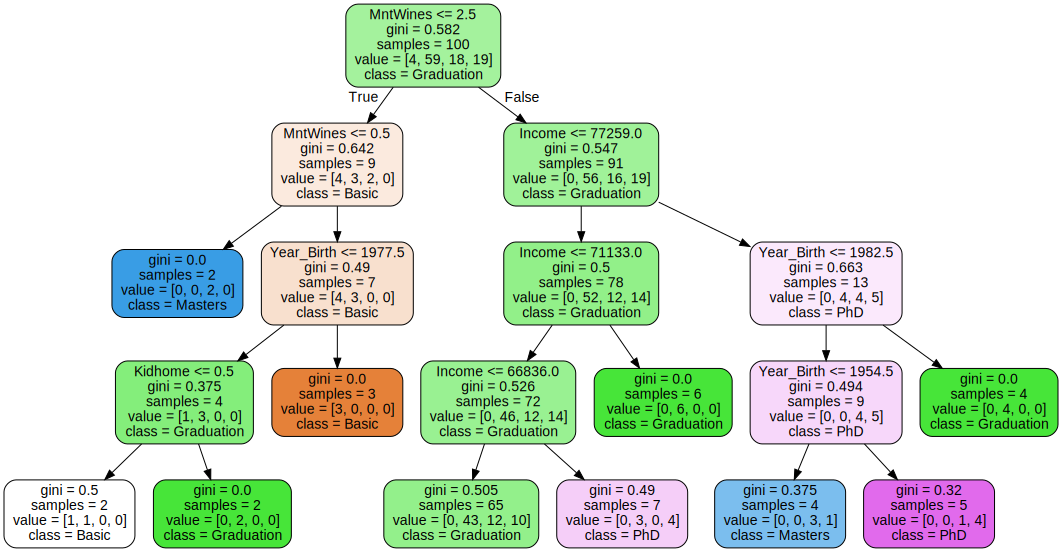

In [ ]:
##Display tree

from graphviz import Source # "Graphical visualization"
from sklearn.tree import export_graphviz

#Create the decision tree as "mkt_tree.dot"
export_graphviz( 
        tree_clf, #Tree object
        out_file=os.path.join(IMAGES_PATH, "mkt_tree.dot"),
        feature_names=np.asarray(COL_LIST[0:4]), #Use constant COL_LIST to name features
        class_names=np.asarray(['Basic','Graduation','Masters','PhD']), #Class of target (y)
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "mkt_tree.dot"))  #Display tree

In [ ]:
##Predict (Question 3)

print("======== features = Year_Birth, Income, Kidhome, MntWines ========") #Print features (X)
print("======== 0 = Basic, 1 = Graduation, 2 = Master, 3 = PhD ========") #Print classification labels for target (y)

input1=[[1943, 98000, 0, 1150]] #input 1 -- Year_Birth= 1943, Income=98000, Kidhome=0, MntWines=900
print(input1,tree_clf.predict(input1)) #Output for input 1

input2=[[1988, 17000, 3, 2]] #input 2 -- Year_Birth= 1988, Income=17000, Kidhome=3, MntWines=2
print(input2,tree_clf.predict(input2)) #Output for input 2

input3=[[1977, 88000, 1, 550]] #input 3 -- Year_Birth= 1977, Income=88000, Kidhome=1, MntWines=550
print(input3,tree_clf.predict(input3)) #Output for input 3

======== features = Year_Birth, Income, Kidhome, MntWines ========
======== 0 = Basic, 1 = Graduation, 2 = Master, 3 = PhD ========
[[1943, 98000, 0, 1150]] [2]
[[1988, 17000, 3, 2]] [0]
[[1977, 88000, 1, 550]] [3]


      Year_Birth  Income  Kidhome  MntWines   Education
783         1972     1.0        1         1  Graduation
1637        1945   217.0        0       217  Graduation
1907        1986    45.0        1        45  Graduation
1110        1954   516.0        0       516  Graduation
1143        1962    56.0        0        56         PhD


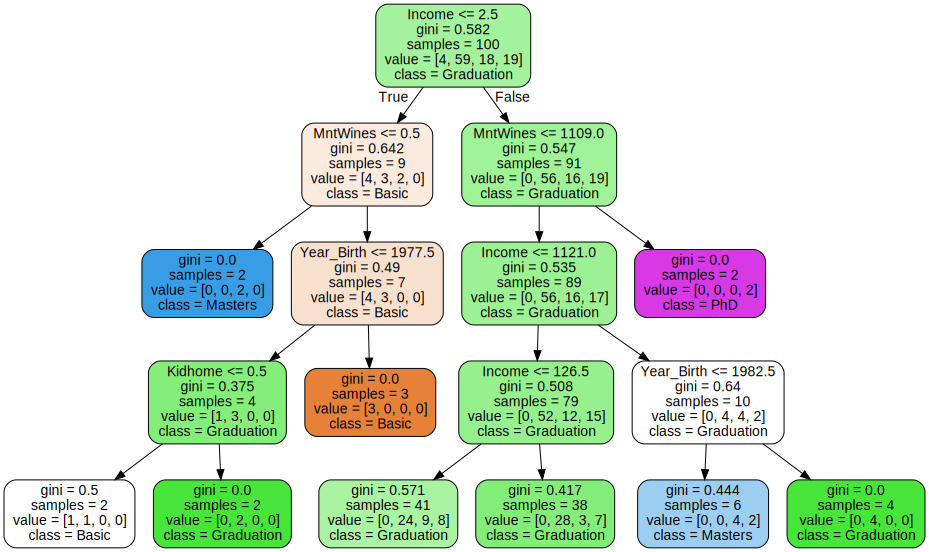

In [ ]:
##Data alteration (Question 5)

mkt_df2=mkt_df.copy(deep=True) #Create new DataFrame for data alteration work with a deep copy
mkt_df2['Income'] = mkt_df2['Income'] -77259 #Reduce all income by 77259
mkt_df2['Income'][mkt_df2['Income']<=0] = mkt_df2['MntWines'] #Set all income less than or equal to 0 equal to MntWines
#Subtract 77259 from all income and then all income less than or equal to 0 is treated as the amount
#an individual spends on wine yearly

print(mkt_df2.head()) #Print head of new DataFrame for visualization purposes

#Make tree for q5
mkt_npa2=mkt_df2.to_numpy() #Change DataFrame to np.array
X2 = mkt_npa2[:,0:4] #X features - Year_Birth, Income, Kidhome, and MntWines
y2 = mkt_npa2[:,4] #Y target - Education
y2 = encoder.fit_transform(y2) #Encode for target variable (Education)


#Use Gini measure in constructing decision tree
tree_clf2 = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=RANDOM_STATE) #Set parameters
                                                      #for max_depth and random_state to defined constants
                                                      #MAX_DEPTH and RANDOM_STATE
#Apply the CART algorithm 
tree_clf2.fit(X2, y2) #Fit tree

#Create the decision tree as "mkt_tree2.dot"
export_graphviz( 
        tree_clf2, #Tree object
        out_file=os.path.join(IMAGES_PATH, "mkt_tree2.dot"),
        feature_names=np.asarray(COL_LIST[0:4]), #Use constant COL_LIST to name features
        class_names=np.asarray(['Basic','Graduation','Masters','PhD']), #Class of target (y)
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "mkt_tree2.dot"))  #Display tree

In [ ]:
##Data alteration outputs (Question 5)

print("======== features = Year_Birth, Income, Kidhome, MntWines ========") #Print features (X)
print("======== 0 = Basic, 1 = Graduation, 2 = Master, 3 = PhD ========") #Print classification labels for target (y)

input1=[[1943, 98000, 0, 1150]] #input 1 -- Year_Birth= 1943, Income=98000, Kidhome=0, MntWines=900
print(input1,tree_clf2.predict(input1)) #Output for input 1 with data alterations

input2=[[1988, 17000, 3, 2]] #input 2 -- Year_Birth= 1988, Income=17000, Kidhome=3, MntWines=2
print(input2,tree_clf2.predict(input2)) #Output for input 2 with data alterations

input3=[[1977, 88000, 1, 550]] #input 3 -- Year_Birth= 1977, Income=88000, Kidhome=1, MntWines=550
print(input3,tree_clf2.predict(input3)) #Output for input 3 with data alterations

======== features = Year_Birth, Income, Kidhome, MntWines ========
======== 0 = Basic, 1 = Graduation, 2 = Master, 3 = PhD ========
[[1943, 98000, 0, 1150]] [3]
[[1988, 17000, 3, 2]] [1]
[[1977, 88000, 1, 550]] [2]


Year_Birth     1992
Income        15253
Kidhome           1
MntWines          1
Education     Basic
Name: 2164, dtype: object
      Year_Birth   Income  Kidhome  MntWines   Education
1740        1992  15253.0        1         1  Graduation
1513        1992  15253.0        1         1  Graduation
1448        1992  15253.0        1         1         PhD
144         1992  15253.0        1         1  Graduation
869         1992  15253.0        1         1  Graduation


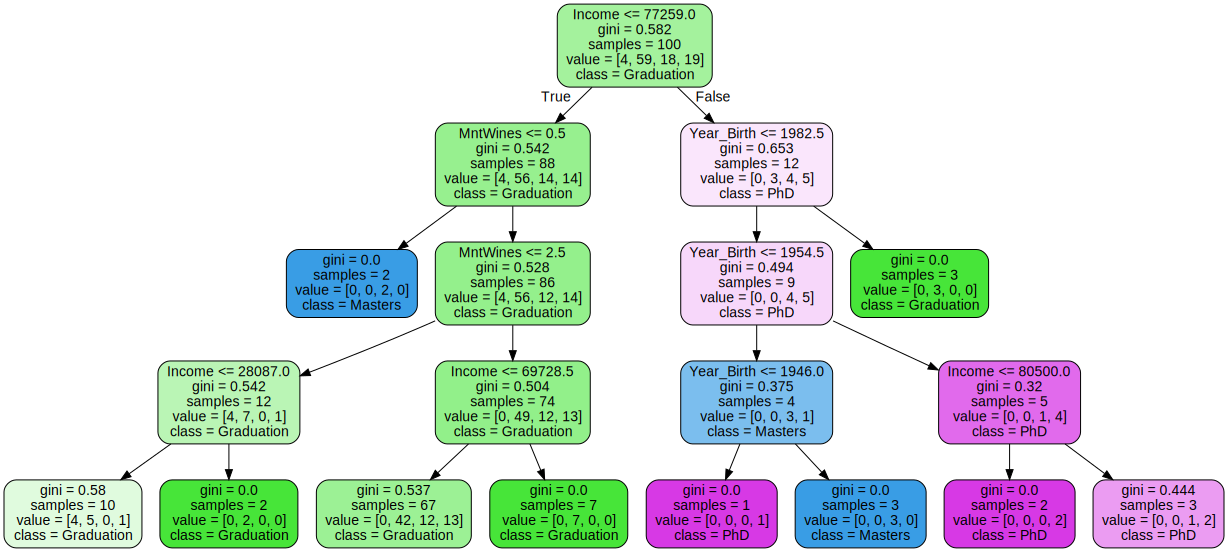

In [ ]:
##Inconsistent data (Question 6)

mkt_df3=mkt_df.copy(deep=True) #Create new DataFrame for inconsistent data work with a deep copy
print(mkt_df.iloc[14,:]) #Find a row with education level = 'Basic'

for e in range(1,6): #Loop through dataset to add inconsistencies to 19, 39, 59, 79, 99 rows
               mkt_df3.iloc[(e*20)-1,0:4]=mkt_df.iloc[14,0:4] #Replace feature data in rows
                                                          #19, 39, 59, 79, 99 with feature data
                                                          #from row 14

print(mkt_df3.iloc[19:100:20,:]) #Print rows 19, 39, 59, 79, 99 to show introduction of data inconsistencies

#Make tree for q6
mkt_npa3=mkt_df3.to_numpy() #Change DataFrame to np.array
X3 = mkt_npa3[:,0:4] #X features - Year_Birth, Income, Kidhome, and MntWines
y3 = mkt_npa3[:,4] #Y target - Education
y3 = encoder.fit_transform(y3) #Encode for target variable (Education)


#Use Gini measure in constructing decision tree
tree_clf3 = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=RANDOM_STATE) #Set parameters
                                                      #for max_depth and random_state to defined constants
                                                      #MAX_DEPTH and RANDOM_STATE
#Apply the CART algorithm 
tree_clf3.fit(X3, y3) #Fit tree

#Create the decision tree as "mkt_tree3.dot"
export_graphviz( 
        tree_clf3, #Tree object
        out_file=os.path.join(IMAGES_PATH, "mkt_tree3.dot"),
        feature_names=np.asarray(COL_LIST[0:4]), #Use constant COL_LIST to name features
        class_names=np.asarray(['Basic','Graduation','Masters','PhD']), #Class of target (y)
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "mkt_tree3.dot"))  #Display tree


In [ ]:
##Inconsistent data outputs (Question 6)
print("======== features = Year_Birth, Income, Kidhome, MntWines ========") #Print features (X)
print("======== 0 = Basic, 1 = Graduation, 2 = Master, 3 = PhD ========") #Print classification labels for target (y)

input1=[[1943, 98000, 0, 1150]] #input 1 -- Year_Birth= 1943, Income=98000, Kidhome=0, MntWines=900
print(input1,tree_clf3.predict(input1)) #Output for input 1 with introduction of data inconsistencies

input2=[[1988, 17000, 3, 2]] #input 2 -- Year_Birth= 1988, Income=17000, Kidhome=3, MntWines=2
print(input2,tree_clf3.predict(input2)) #Output for input 2 with introduction of data inconsistencies

input3=[[1977, 88000, 1, 550]] #input 3 -- Year_Birth= 1977, Income=88000, Kidhome=1, MntWines=550
print(input3,tree_clf3.predict(input3)) #Output for input 3 with introduction of data inconsistencies

======== features = Year_Birth, Income, Kidhome, MntWines ========
======== 0 = Basic, 1 = Graduation, 2 = Master, 3 = PhD ========
[[1943, 98000, 0, 1150]] [3]
[[1988, 17000, 3, 2]] [1]
[[1977, 88000, 1, 550]] [3]


APPENDIX [3]

      Year_Birth   Income  Kidhome  MntWines   Education
783         1972  30467.0        1         1  Graduation
1637        1945  69755.0        0       217  Graduation
1907        1986  33235.0        1        45  Graduation
1110        1954  76773.0        2       516  Graduation
1143        1962  33419.0        0        56         PhD


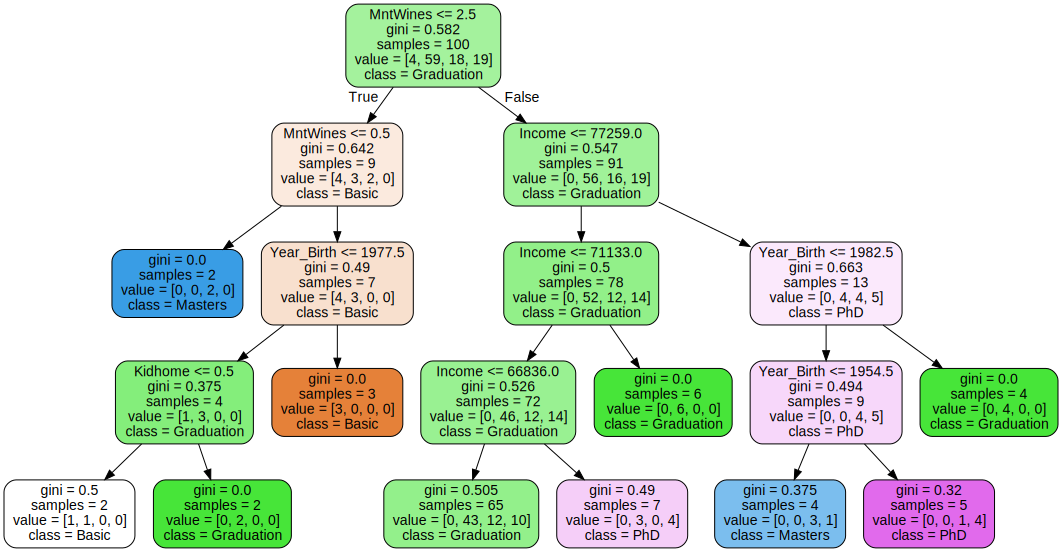

In [ ]:
##Data alteration (Alternative)

mkt_df4=mkt_df.copy(deep=True) #Create new DataFrame for different data alteration work with a deep copy
for e in range(1,5): #Loop through DataFrame to consider each 250 spent on wine yearly as an additional child
  mkt_df4.loc[mkt_df4['MntWines'] >= e*250, 'Kidhome'] = mkt_df4['Kidhome']+1
#Given looping through range(1,5), this would consider a maximum of 4 additional children at a yearly wine expense of 1000.
#1 additional child at 250 yearly wine expense, 2 additional children at 500 yearly wine expense,
#3 additional children at 750 yearly wine expense, and 4 additional children at 1000 or greater wine expense


print(mkt_df4.head()) #Print head of new DataFrame for visualization purposes

#Make tree for appendix data alteration
mkt_npa4=mkt_df4.to_numpy() #Change DataFrame to np.array
X4 = mkt_npa4[:,0:4] #X features - Year_Birth, Income, Kidhome, and MntWines
y4 = mkt_npa4[:,4] #Y target - Education
y4 = encoder.fit_transform(y4) #Encode for target variable (Education)


#Use Gini measure in constructing decision tree
tree_clf4 = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=RANDOM_STATE) #Set parameters
                                                      #for max_depth and random_state to defined constants
                                                      #MAX_DEPTH and RANDOM_STATE
#Apply the CART algorithm 
tree_clf4.fit(X4, y4) #Fit tree

#Create the decision tree as "mkt_tree4.dot"
export_graphviz( 
        tree_clf4, #Tree object
        out_file=os.path.join(IMAGES_PATH, "mkt_tree4.dot"),
        feature_names=np.asarray(COL_LIST[0:4]), #Use constant COL_LIST to name features
        class_names=np.asarray(['Basic','Graduation','Masters','PhD']), #Class of target (y)
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "mkt_tree4.dot"))  #Display tree

In [ ]:
##Data alteration outputs (Appendix)

print("======== features = Year_Birth, Income, Kidhome, MntWines ========") #Print features (X)
print("======== 0 = Basic, 1 = Graduation, 2 = Master, 3 = PhD ========") #Print classification labels for target (y)

input1=[[1943, 98000, 0, 1150]] #input 1 -- Year_Birth= 1943, Income=98000, Kidhome=0, MntWines=900
print(input1,tree_clf4.predict(input1)) #Output for input 1 with appendix data alterations

input2=[[1988, 17000, 3, 2]] #input 2 -- Year_Birth= 1988, Income=17000, Kidhome=3, MntWines=2
print(input2,tree_clf4.predict(input2)) #Output for input 2 with appendix data alterations

input3=[[1977, 88000, 1, 550]] #input 3 -- Year_Birth= 1977, Income=88000, Kidhome=1, MntWines=550
print(input3,tree_clf4.predict(input3)) #Output for input 3 with appendix data alterations

======== features = Year_Birth, Income, Kidhome, MntWines ========
======== 0 = Basic, 1 = Graduation, 2 = Master, 3 = PhD ========
[[1943, 98000, 0, 1150]] [2]
[[1988, 17000, 3, 2]] [0]
[[1977, 88000, 1, 550]] [3]


In [ ]:
##Means of MntWines by Education level

print("======== Mean MntWines among all individuals with 'Basic' Education level ========") #Print
print(mkt_df.loc[(mkt_df.Education == 'Basic'),'MntWines'].mean()) #Mean of MntWines by 'Basic' Education level
print('')

print("======== Mean MntWines among all individuals with 'Graduation' Education level ========") #Print
print(mkt_df.loc[(mkt_df.Education == 'Graduation'),'MntWines'].mean()) #Mean of MntWines by 'Graduation' Education level
print('')

print("======== Mean MntWines among all individuals with 'Master' Education level ========") #Print
print(mkt_df.loc[(mkt_df.Education == 'Master'),'MntWines'].mean()) #Mean of MntWines by 'Master' Education level
print('')

print("======== Mean MntWines among all individuals with 'PhD' Education level ========") #Print
print(mkt_df.loc[(mkt_df.Education == 'PhD'),'MntWines'].mean()) #Mean of MntWines by 'PhD' Education level
print('')

======== Mean MntWines among all individuals with 'Basic' Education level ========
1.25

======== Mean MntWines among all individuals with 'Graduation' Education level ========
261.3220338983051

======== Mean MntWines among all individuals with 'Master' Education level ========
246.83333333333334

======== Mean MntWines among all individuals with 'PhD' Education level ========
391.2631578947368

